In [1]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import lognorm
from scipy.stats import norm
import math
import seaborn as sns
from random import sample
import pandas 
import src.test_strategies

([1], 1, 0)
([1], 1, 0)


In [2]:
graph = {}
with open('fb_graph.pkl', 'rb') as f:
    graph = pickle.load(f)
G = nx.from_dict_of_dicts(graph)

In [3]:
for i in range(len(G.nodes)):
    G.nodes[i]["status"] = "S"
nx.set_node_attributes(G, False, name = "confirmed positive")
nx.set_node_attributes(G, False, name = "tested")
nx.set_node_attributes(G, False, name = "infected")
nx.set_edge_attributes(G, name = "weight", values = 1)

In [4]:
G.nodes.data()

NodeDataView({0: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 1: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 2: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 3: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 4: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 5: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 6: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 7: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 8: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 9: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 10: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 11: {'status': 'S', 'confirmed positive': False, '

In [25]:
def run_iteration(G, test = False):
    S_n = [n for n,v in G.nodes(data=True) if v['status'] == 'S']
    E_n = [n for n,v in G.nodes(data=True) if v['status'] == 'E']
    I_n = [n for n,v in G.nodes(data=True) if v['status'] == 'I']
    H_n = [n for n,v in G.nodes(data=True) if v['status'] == 'H']
    for i in I_n:
        for neighbor in G.neighbors(i):
            if G.nodes[neighbor]["status"] == "S":
                # Multiplying by the weight of the edge is supposed to model decreased 
                # contact after a person is in quarentine
                if random.random() < 0.004576659038901602*G[i][neighbor]["weight"]:
                    G.nodes[neighbor]["status"] = "E"
                    G.nodes[neighbor]["days_since_E"] = 0
    for e in E_n:
        G.nodes[e]["days_since_E"] += 1
        days_since_E = G.nodes[e]["days_since_E"]
        if days_since_E == 14: # if you've been asymp for 14 days, you recover
            G.nodes[e]["status"] = "R"
        mu = 1.621
        std = 0.418
        prob = lognorm.pdf(days_since_E, s=std, scale=np.exp(mu)) * 0.8
        if random.random() < prob:
            G.nodes[e]["status"] = "I"
            G.nodes[e]["days_since_I"] = 0
    for i in I_n:
        G.nodes[i]["days_since_E"] += 1
        G.nodes[i]["days_since_I"] += 1
        days_since_I = G.nodes[i]["days_since_I"]
        dist = norm(10, 1) 
        prob = dist.pdf(days_since_I) * 0.1755
        if random.random() < prob:
            G.nodes[i]["status"] = "H"
            G.nodes[i]["days_since_H"] = 0
    for h in H_n:
        G.nodes[h]["days_since_H"] += 1
        G.nodes[h]["days_since_E"] += 1
        if G.nodes[h]["days_since_E"] == 14:
            if random.random() < 0.01:
                G.nodes[h]["status"] = "D"
            else:
                G.nodes[h]["status"] = "R"
                
    # If we do testing, we now update the nodes depending on the test passed in 
    if test == "random":
        src.test_strategies.test_strat_random_sample(G, 50)
    elif test == "high_connect":
        src.test_strategies.test_strat_high_contact(G, 150)
    elif test == "pool_family":
        src.test_strategies.test_strat_pool_family(G)
    elif test == "most_infected":
        src.test_strategies.test_strat_most_infected(G,50)
    

In [6]:
# Choose 10 people at random to be infected initially
T = G.copy()
first_infected = random.sample(list(T.nodes()), 10)

In [7]:
# Copy the graph 4 times so we can use one clean copy for each modeling iteration 
T = G.copy()
T_1 = G.copy() 
T_2 = G.copy()
T_3 = G.copy()
T_4 = G.copy()
# Also make each copy reflect the infected status from the initial infections
for i in first_infected:
    T.nodes[i]["status"] = "I"
    T.nodes[i]["days_since_E"] = 0
    T.nodes[i]["days_since_I"] = 0
for i in first_infected:
    T_1.nodes[i]["status"] = "I"
    T_1.nodes[i]["days_since_E"] = 0
    T_1.nodes[i]["days_since_I"] = 0
for i in first_infected:
    T_2.nodes[i]["status"] = "I"
    T_2.nodes[i]["days_since_E"] = 0
    T_2.nodes[i]["days_since_I"] = 0
for i in first_infected:
    T_3.nodes[i]["status"] = "I"
    T_3.nodes[i]["days_since_E"] = 0
    T_3.nodes[i]["days_since_I"] = 0
for i in first_infected:
    T_4.nodes[i]["status"] = "I"
    T_4.nodes[i]["days_since_E"] = 0
    T_4.nodes[i]["days_since_I"] = 0

In [23]:
quarantine_infectivity = 0.1
confirmed_negative_infectivity = 1

In [ ]:
# Store the number of infections

infected_num_family = []

no_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(100)])
random_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(100)])
connect_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(100)])
infected_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(100)])

# Run each model for 50 time steps
print("Starting the no testing model")
for j in range(100):
    infected_num = []
    T = G.copy()
    first_infected = random.sample(list(T.nodes()), 10)
    for infected in first_infected:
        T.nodes[infected]["status"] = "I"
        T.nodes[infected]["days_since_E"] = 0
        T.nodes[infected]["days_since_I"] = 0
    for i in range(50):
        I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
        infected_num.append(len(I_n))
        run_iteration(T)
    no_test_df[j] = infected_num
    if j % 10 ==0:
        print("done", j, "iter")
no_test_df.to_csv("simulations/no_test.csv")

print("Starting the random testing model")
for j in range(100):
    infected_num_random = []
    T_1 = G.copy() 
    first_infected = random.sample(list(T_1.nodes()), 10)
    for i in first_infected:
        T_1.nodes[i]["status"] = "I"
        T_1.nodes[i]["days_since_E"] = 0
        T_1.nodes[i]["days_since_I"] = 0
    for i in range(50):
        I_n = [n for n,v in T_1.nodes(data=True) if v['status'] == 'I']
        infected_num_random.append(len(I_n))
        run_iteration(T_1, "random")
    random_test_df[j] = infected_num_random
    if j % 10 ==0:
        print("done", j, "iter")

print("Starting the testing highly connected people model")
for j in range(100):
    infected_num_connect = []
    T_2 = G.copy()
    first_infected = random.sample(list(T_2.nodes()), 10)
    for i in first_infected:
        T_2.nodes[i]["status"] = "I"
        T_2.nodes[i]["days_since_E"] = 0
        T_2.nodes[i]["days_since_I"] = 0
    for i in range(50):
        I_n = [n for n,v in T_2.nodes(data=True) if v['status'] == 'I']
        infected_num_connect.append(len(I_n))
        run_iteration(T_2, "high_connect")
    connect_test_df[j] = infected_num_connect
    if j % 10 ==0:
        print("done", j, "iter")
        
# print("Starting the testing most infected people model")
# for j in range(5):
#     infected_num_infect = []
#     T_4 = G.copy()
#     first_infected = random.sample(list(T_4.nodes()), 10)
#     for i in first_infected:
#         T_4.nodes[i]["status"] = "I"
#         T_4.nodes[i]["days_since_E"] = 0
#         T_4.nodes[i]["days_since_I"] = 0
#     for i in range(50):
#         I_n = [n for n,v in T_4.nodes(data=True) if v['status'] == 'I']
#         infected_num_infect.append(len(I_n))
#         run_iteration(T_4, "most_infected")
#     infected_test_df[j] = infected_num_infect
#     if j % 10 ==0:
#         print("done", j, "iter")

        
#TODO: This one takes a long time to run because we are finding the cliques each time,
# instead we should probably change it so we find the cliques once, store it globally 
# or pass it into the function as a parameter to speed up runtime
        
# for i in range(1):
#     I_n = [n for n,v in T_3.nodes(data=True) if v['status'] == 'I']
#     infected_num_family.append(len(I_n))
#     run_iteration(T_3, "pool_family")

Starting the no testing model
done 0 iter
done 10 iter
done 20 iter
done 30 iter
done 40 iter
done 50 iter
done 60 iter
done 70 iter
done 80 iter
done 90 iter
Starting the random testing model
done 0 iter
done 10 iter
done 20 iter
done 30 iter
done 40 iter
done 50 iter
done 60 iter
done 70 iter
done 80 iter
done 90 iter
Starting the testing highly connected people model
done 0 iter
done 10 iter
done 20 iter
done 30 iter
done 40 iter
done 50 iter
done 60 iter
done 70 iter


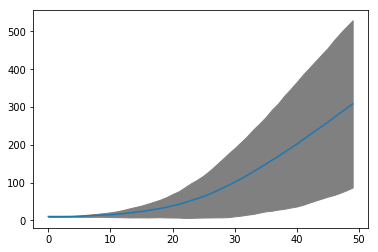

In [21]:
plt.plot([i for i in range(50)], no_test_df.mean(axis = 1), label = "Untested")
plt.fill_between([i for i in range(50)], no_test_df.mean(axis = 1) + 2*no_test_df.std(axis = 1), no_test_df.mean(axis = 1) - 2*no_test_df.std(axis = 1), color = "grey")
plt.show()

In [18]:
S_n = [n for n,v in T.nodes(data=True) if v['status'] == 'S']
E_n = [n for n,v in T.nodes(data=True) if v['status'] == 'E']
I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
H_n = [n for n,v in T.nodes(data=True) if v['status'] == 'H']

In [19]:
print(E_n)
print(I_n)
print(H_n)

[34, 368, 373, 376, 388, 397, 404, 405, 434, 452, 469, 481, 483, 492, 494, 567, 591, 604, 606, 622, 644, 669, 898, 906, 921, 927, 942, 960, 967, 973, 976, 979, 990, 996, 1003, 1013, 1029, 1054, 1059, 1074, 1079, 1080, 1081, 1086, 1113, 1121, 1129, 1142, 1146, 1153, 1156, 1184, 1217, 1221, 1227, 1242, 1250, 1255, 1259, 1265, 1267, 1271, 1287, 1288, 1293, 1313, 1318, 1322, 1334, 1335, 1341, 1345, 1347, 1348, 1355, 1364, 1367, 1373, 1376, 1390, 1396, 1406, 1408, 1413, 1416, 1423, 1426, 1429, 1443, 1449, 1450, 1451, 1456, 1471, 1487, 1488, 1503, 1505, 1507, 1508, 1530, 1541, 1550, 1554, 1556, 1598, 1611, 1613, 1618, 1622, 1634, 1638, 1655, 1660, 1661, 1671, 1673, 1680, 1682, 1691, 1702, 1715, 1716, 1728, 1742, 1745, 1746, 1752, 1764, 1765, 1769, 1772, 1774, 1788, 1791, 1793, 1795, 1804, 1806, 1823, 1827, 1835, 1847, 1862, 1876, 1892, 1896, 2406, 2694, 2720, 2721, 2732, 2744, 2757, 2782, 2783, 2785, 2787, 2793, 2810, 2826, 2839, 2859, 2871, 2884, 2890, 2894, 2910, 2922, 2947, 2959, 2961, 29

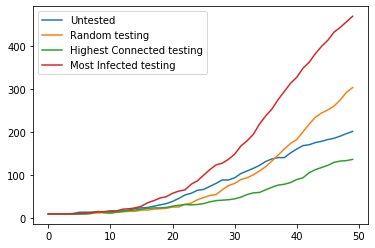

In [99]:
plt.plot([i for i in range(50)], infected_num[0:50], label = "Untested")
plt.plot([i for i in range(50)], infected_num_random[0:50], label = "Random testing")
plt.plot([i for i in range(50)], infected_num_connect[0:50], label = "Highest Connected testing")
plt.plot([i for i in range(50)], infected_num_infect[0:50], label = "Most Infected testing")

plt.legend()
plt.show()

In [83]:
len(test_strat_most_infected(T,50))

[1970, 3890, 80, 856, 2494, 1321, 2536, 1020, 2291, 1078, 1006, 361, 836, 3336, 2461, 1985, 1587, 2155, 2258, 1873, 264, 3527, 1384, 2281, 2231, 1988, 3782, 1665, 668, 3754, 631]


50